# Import necessary libraries

In [1]:
import os
import re
import cv2
import pickle
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# Visualizing data

Number of training samples: 5981
Number of test samples: 857
Number of validation samples: 1709


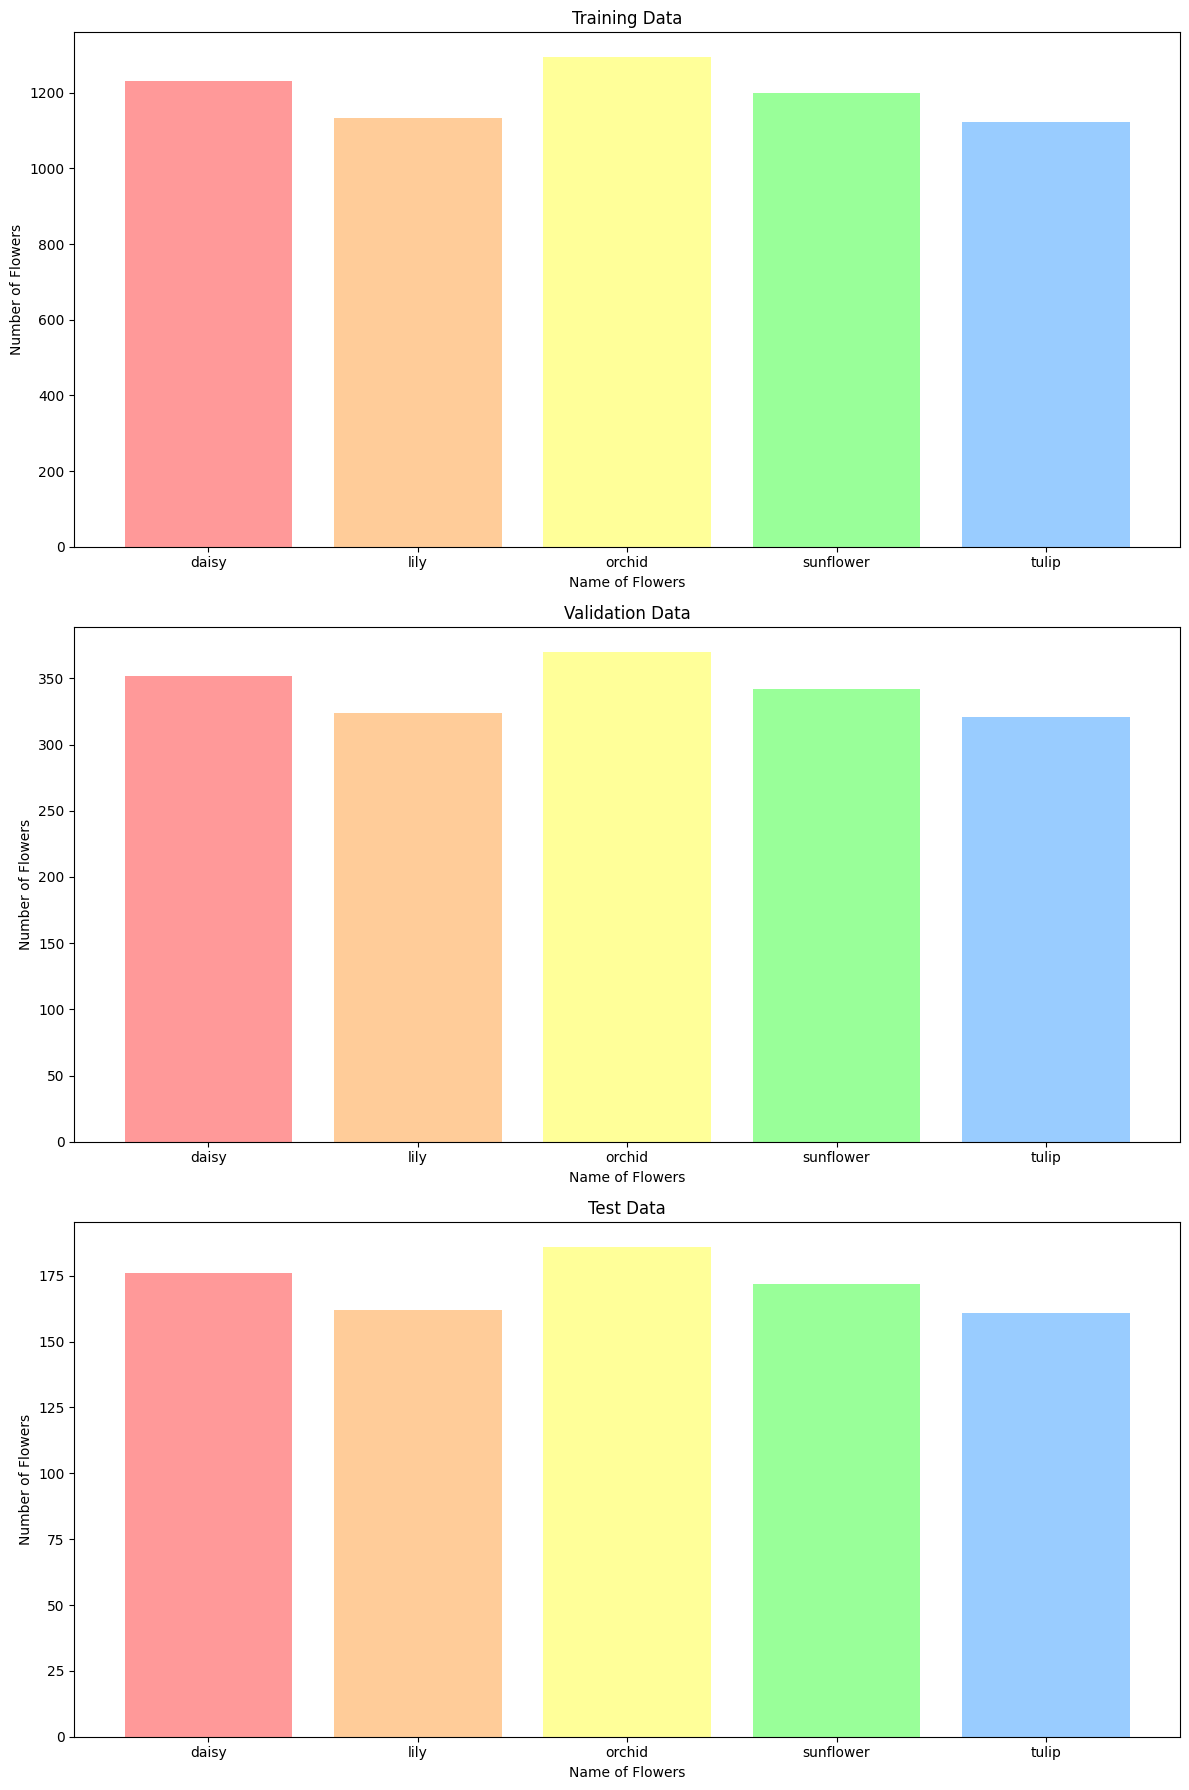

In [2]:
import os
import matplotlib.pyplot as plt

def get_folder_statistics(directory):
    folders = []
    file_counts = []
    num_files = 0
    
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            folders.append(folder)
            count = len(os.listdir(folder_path))
            file_counts.append(count)
            num_files += count
            
    return folders, file_counts, num_files

# Directories
train_dir = 'flowers/train'
val_dir = 'flowers/val'
test_dir = 'flowers/test'

# Get statistics for each dataset
folders_train, file_counts_train, num_train = get_folder_statistics(train_dir)
folders_val, file_counts_val, num_val = get_folder_statistics(val_dir)
folders_test, file_counts_test, num_test = get_folder_statistics(test_dir)

print('Number of training samples:', num_train)
print('Number of test samples:', num_test)
print('Number of validation samples:', num_val)

# Plot bar charts for each dataset in one figure
colors = ["#FF9999", "#FFCC99", "#FFFF99", "#99FF99", "#99CCFF", '#FFFC23', '#FF9215']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# Training data
ax1.bar(folders_train, file_counts_train, color=colors)
ax1.set_xlabel('Name of Flowers')
ax1.set_ylabel('Number of Flowers')
ax1.set_title('Training Data')

# Validation data
ax2.bar(folders_val, file_counts_val, color=colors)
ax2.set_xlabel('Name of Flowers')
ax2.set_ylabel('Number of Flowers')
ax2.set_title('Validation Data')

# Test data
ax3.bar(folders_test, file_counts_test, color=colors)
ax3.set_xlabel('Name of Flowers')
ax3.set_ylabel('Number of Flowers')
ax3.set_title('Test Data')

plt.tight_layout()
plt.show()


# Data processing

In [3]:
import os
import cv2
import numpy as np
from skimage.feature import hog


def compute_color_histogram(image, bins=(8, 8, 8)):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Compute the color histogram
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def load_images(folder_path, flower_types):
    features = []
    labels = []
    for flower in flower_types:
        flower_folder = os.path.join(folder_path, flower)
        for img in os.listdir(flower_folder):
            img_path = os.path.join(flower_folder, img)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = np.array(image).astype('uint8')
            image = cv2.resize(image, (64, 64))
            grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Extract HOG features
            hog_features = hog(grey_image, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")

            # Extract color histogram features
            color_hist = compute_color_histogram(image)

            # Concatenate HOG and color histogram features
            combined_features = np.hstack((hog_features, color_hist))

            features.append(combined_features)
            labels.append(flower)

    return features, labels

In [4]:
# Load and preprocess data
# flower_types = [ 'Orchid', 'Sunflower', 'Tulip', 'Lotus', 'Lilly']
flower_types = [folder for folder in os.listdir(train_dir)]
# flower_types = ['daisy', 'danelion','lily', 'orchid', 'sunflower', 'tulip'] 
X_train, y_train = load_images(train_dir, flower_types)
X_val, y_val = load_images(val_dir, flower_types)
X_test, y_test = load_images(test_dir, flower_types)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
# Kiểm tra dữ liệu sau khi tải
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 5981
Number of validation samples: 1709
Number of testing samples: 857


In [5]:
# Encode labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

print("Label to Encoded Mapping:")
for original_label, encoded_label in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"{original_label} -> {encoded_label}")

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Label to Encoded Mapping:
daisy -> 0
lily -> 1
orchid -> 2
sunflower -> 3
tulip -> 4


In [6]:
# Apply PCA
pca = PCA(n_components=0.95)
print(X_train.shape)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

(5981, 2276)
(5981, 782)


# Initiating necessary functions

In [13]:
def evaluate_model(model, X_train, X_val, y_train, y_val):
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    # Dự đoán trên tập validation
    y_pred = model.predict(X_val)

    # Tính các chỉ số đánh giá
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    # In các chỉ số đánh giá
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # In báo cáo phân loại chi tiết
    print("\nClassification Report:\n")
    print(classification_report(y_val, y_pred))

    # Vẽ confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    classes = np.unique(y_val)  # Lấy các nhãn lớp tương ứng với thực tế
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Ghi nhãn trên các ô của ma trận
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [8]:
import cv2
import matplotlib.pyplot as plt

def plot_color_histogram(image, h_bins=180, s_bins=256, v_bins=256):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Compute the histogram for each channel
    h_hist = cv2.calcHist([hsv_image], [0], None, [h_bins], [0, 180])
    s_hist = cv2.calcHist([hsv_image], [1], None, [s_bins], [0, 256])
    v_hist = cv2.calcHist([hsv_image], [2], None, [v_bins], [0, 256])
    
    # Plot the histograms
    plt.figure(figsize=(12, 6))
    
    plt.subplot(131)
    plt.plot(h_hist, color='r')
    plt.title('Hue Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    
    plt.subplot(132)
    plt.plot(s_hist, color='g')
    plt.title('Saturation Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    
    plt.subplot(133)
    plt.plot(v_hist, color='b')
    plt.title('Value Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# SVM

Accuracy: 0.7894
Precision: 0.7932
Recall: 0.7894
F1-score: 0.7901

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.83      0.77       352
           1       0.74      0.71      0.72       324
           2       0.82      0.81      0.81       370
           3       0.90      0.83      0.86       342
           4       0.79      0.76      0.78       321

    accuracy                           0.79      1709
   macro avg       0.79      0.79      0.79      1709
weighted avg       0.79      0.79      0.79      1709



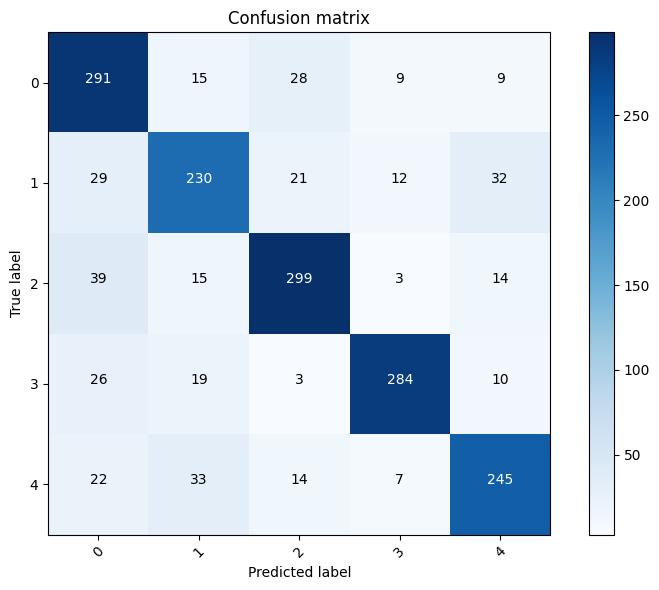

In [23]:
# Initialize SVM model
svm = SVC(kernel= 'linear', C = 15)

evaluate_model(svm, X_train_pca, X_val_pca, y_train_encoded, y_val_encoded)

# LightGBM

Accuracy: 0.7141
Precision: 0.7141
Recall: 0.7141
F1-score: 0.7140

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       176
           1       0.68      0.71      0.69       162
           2       0.73      0.73      0.73       186
           3       0.73      0.74      0.73       172
           4       0.76      0.75      0.76       161

    accuracy                           0.71       857
   macro avg       0.71      0.71      0.71       857
weighted avg       0.71      0.71      0.71       857



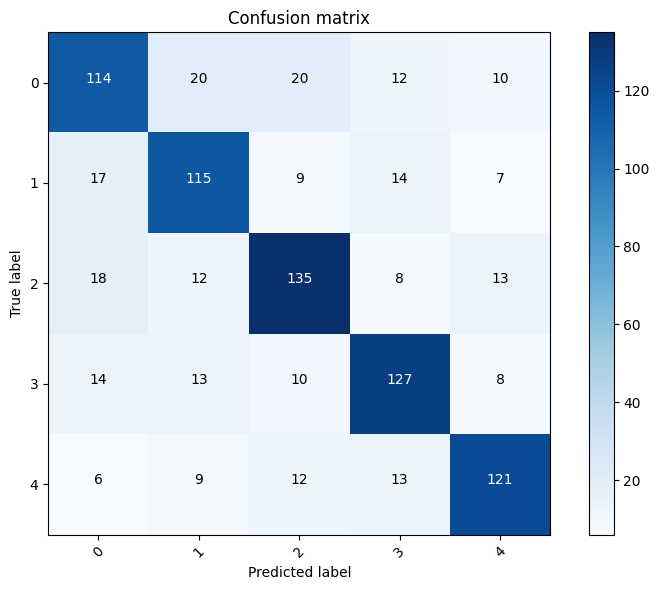

In [16]:
# Initialize LightGBM model
import lightgbm as lgb
lightgbm = lgb.LGBMClassifier(objective= 'multiclass', 
                              num_class=5,
                             learning_rate=0.35, 
                             verbosity=-1)

# Evaluate the LightGBM model
evaluate_model(lightgbm, X_val_pca, X_test_pca, y_val_encoded, y_test_encoded)

# Demo

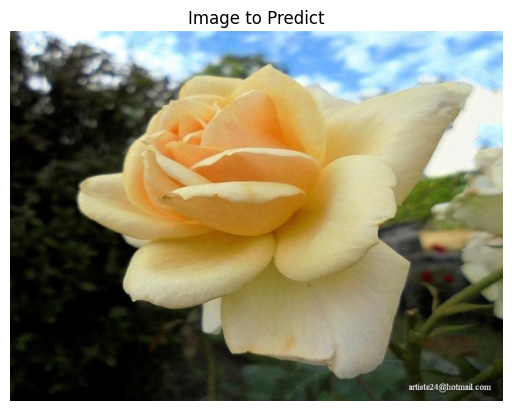

In [ ]:
img_path = r'flowers\test\rose\35207387216_02ca0143b5_o.jpg' 

#Processing img  
image = cv2.imread(img_path)

# plot_color_histogram(image)
# Display the image to be predicted
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image to Predict")
plt.axis('off')
plt.show()

image = np.array(image).astype('uint8')
image = cv2.resize(image, (64, 64))
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Extract HOG features
hog_features, hog_image  = hog(grey_image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2", visualize=True)

# Extract color histogram features
color_hist = compute_color_histogram(image)

# Concatenate HOG and color histogram features
combined_features = np.hstack((hog_features, color_hist))

demo_X = [combined_features] 
scaled_demo_X = scaler.transform(demo_X)
pca_demo_X = pca.transform(scaled_demo_X) 

In [ ]:
svm_pred = svm.predict(pca_demo_X)
print(encoder.inverse_transform(svm_pred))

['rose']


In [ ]:
light_pred = lightgbm.predict(pca_demo_X)
print(encoder.inverse_transform(light_pred))

['rose']
